In [1]:
import itertools
import functools
from collections import Counter
import pandas
from matplotlib import pyplot as pl
import numpy as np
import gc
from scipy.sparse import lil_matrix
training_fname = 'data/PrediqtTrainData.Sample.5000000.csv'
airports_fname = 'data/PrediqtAirports.csv'
testing_fname = 'data/PrediqtTestDataSmall.csv'

In [2]:
training_data = pandas.read_csv(training_fname, dtype={
    'PRICE': float, 
})

In [3]:
for item, itemtype in {'OUTBOUND_DATE': 'datetime64',  # can't believe you can't do this when parsing
    'INBOUND_DATE': 'datetime64',
    'SEARCH_DATEHOUR': 'datetime64[ns]',}.iteritems():
    print item
    training_data[item] = training_data[item].astype(itemtype)
gc.collect()

OUTBOUND_DATE
SEARCH_DATEHOUR
INBOUND_DATE


0

#Prices

In [4]:
training_data = training_data.sort_index(by='PRICE')

In [5]:
price_counts = training_data.PRICE.value_counts(sort=False)

In [6]:
num_prices = len(training_data.PRICE)
num_buckets = 150.
buckets = [0.]
running_total = 0
for price, count in price_counts.sort_index().iteritems():
    running_total += count
    if running_total >= num_prices / num_buckets:
        buckets.append(price)
        running_total = 0
buckets.append(price * 1.01)
print buckets
del price_counts

[0.0, 42.090000000000003, 54.539999999999999, 65.200000000000003, 75.180000000000007, 84.540000000000006, 93.579999999999998, 101.37, 109.22, 117.23, 124.98, 132.09999999999999, 139.38999999999999, 145.88, 151.69999999999999, 157.97, 163.19999999999999, 169.18000000000001, 173.97999999999999, 179.97999999999999, 185.28, 190.13999999999999, 195.49000000000001, 199.97999999999999, 204.97999999999999, 209.97999999999999, 215.28999999999999, 219.97999999999999, 225.03999999999999, 229.97999999999999, 235.31, 239.97999999999999, 245.40000000000001, 250.03999999999999, 256.12, 260.98000000000002, 268.79000000000002, 273.80000000000001, 279.98000000000002, 287.73000000000002, 294.49000000000001, 300.98000000000002, 309.98000000000002, 319.22000000000003, 326.98000000000002, 335.56, 343.29000000000002, 353.22000000000003, 362.81, 373.98000000000002, 384.76999999999998, 396.98000000000002, 409.23000000000002, 421.81, 435.98000000000002, 449.98000000000002, 464.98000000000002, 479.98000000000002

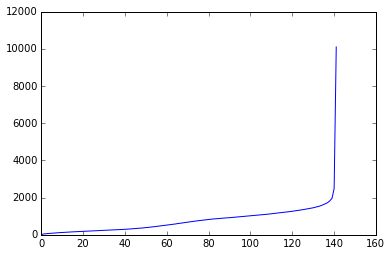

In [7]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot(buckets)
pl.show()

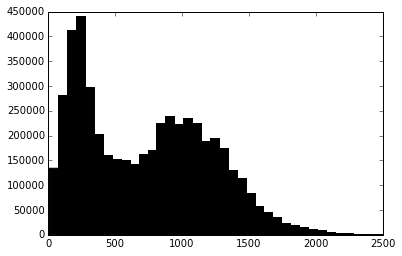

In [8]:
pl.hist(training_data.PRICE, num_buckets, color='black')
pl.xlim([0, 2500])
pl.show()

In [9]:
bucket_counts = [0 for __ in xrange(int(num_buckets) + 1)]
bucket_ranges = zip(xrange(int(num_buckets) + 1), buckets, buckets[1:])
print len(training_data.PRICE)
for i_, price in enumerate(training_data.PRICE):
    for i, low, high in bucket_ranges:
        if low <= price <= high:
            bucket_counts[i] += 1
            break
    if bucket_ranges[0][-1] < price:
        bucket_ranges = bucket_ranges[1:]
        print 'adjusting range', bucket_ranges[0]

5000000
adjusting range (1, 42.090000000000003, 54.539999999999999)
adjusting range (2, 54.539999999999999, 65.200000000000003)
adjusting range (3, 65.200000000000003, 75.180000000000007)
adjusting range (4, 75.180000000000007, 84.540000000000006)
adjusting range (5, 84.540000000000006, 93.579999999999998)
adjusting range (6, 93.579999999999998, 101.37)
adjusting range (7, 101.37, 109.22)
adjusting range (8, 109.22, 117.23)
adjusting range (9, 117.23, 124.98)
adjusting range (10, 124.98, 132.09999999999999)
adjusting range (11, 132.09999999999999, 139.38999999999999)
adjusting range (12, 139.38999999999999, 145.88)
adjusting range (13, 145.88, 151.69999999999999)
adjusting range (14, 151.69999999999999, 157.97)
adjusting range (15, 157.97, 163.19999999999999)
adjusting range (16, 163.19999999999999, 169.18000000000001)
adjusting range (17, 169.18000000000001, 173.97999999999999)
adjusting range (18, 173.97999999999999, 179.97999999999999)
adjusting range (19, 179.97999999999999, 185.28

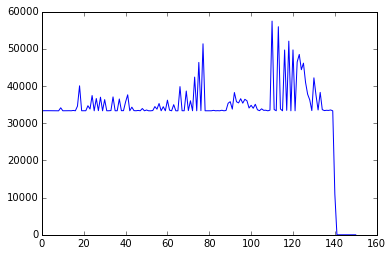

In [10]:
%matplotlib inline
pl.plot(bucket_counts)
pl.show()

I think bucket_counts looks better than bin_counts.

In [11]:
print buckets

[0.0, 42.090000000000003, 54.539999999999999, 65.200000000000003, 75.180000000000007, 84.540000000000006, 93.579999999999998, 101.37, 109.22, 117.23, 124.98, 132.09999999999999, 139.38999999999999, 145.88, 151.69999999999999, 157.97, 163.19999999999999, 169.18000000000001, 173.97999999999999, 179.97999999999999, 185.28, 190.13999999999999, 195.49000000000001, 199.97999999999999, 204.97999999999999, 209.97999999999999, 215.28999999999999, 219.97999999999999, 225.03999999999999, 229.97999999999999, 235.31, 239.97999999999999, 245.40000000000001, 250.03999999999999, 256.12, 260.98000000000002, 268.79000000000002, 273.80000000000001, 279.98000000000002, 287.73000000000002, 294.49000000000001, 300.98000000000002, 309.98000000000002, 319.22000000000003, 326.98000000000002, 335.56, 343.29000000000002, 353.22000000000003, 362.81, 373.98000000000002, 384.76999999999998, 396.98000000000002, 409.23000000000002, 421.81, 435.98000000000002, 449.98000000000002, 464.98000000000002, 479.98000000000002

In [12]:
len(buckets)

142

In [147]:
def convert(num, buckets=buckets, bucket_ranges=None):
    """go from 0..1 to larger"""
    buckets = list(buckets)
    if bucket_ranges is None:
        bucket_ranges = itertools.izip(buckets, buckets[1:])
    step = 1 / float(len(buckets))
    cumsum = 0
    for low, high in bucket_ranges:
        if cumsum <= num < cumsum + step:
            t = (num - cumsum) / step
            return (1 - t) * low + t * high
        cumsum += step
    t = (num - (cumsum - step)) / step
    return (1 - t) * low + t * high

def reverse_convert(num, buckets, _range=range(12)):
    """go from larger to 0..1"""
    # Binary search, because I couldn't spend time to figure it out properly... oh well
    buckets = list(buckets)
    bucket_ranges = zip(buckets, buckets[1:])
    high, low = 0., 1.
    for __ in _range:
        mid = (high + low) / 2.
        result = convert(mid, buckets=buckets, bucket_ranges=bucket_ranges)
        if abs(result - num) < 0.001:
            break
        if result > num:
            low = mid
        else:
            high = mid
    return mid

In [14]:
print convert(.992)
print convert(.9925)
print convert(.993)
print convert(.9935)

9063.4635872
9603.531463
10143.5993388
10683.6672146


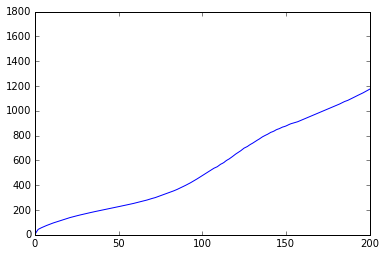

In [15]:
%matplotlib inline
pl.plot([convert(i / 250.) for i in xrange(250)])
pl.xlim([0, 200])
pl.ylim([0, 1800])
pl.show()

#Datetimes

In [16]:
training_data['SEARCH_TO_OUTBOUND'] = training_data.OUTBOUND_DATE - training_data.SEARCH_DATEHOUR

In [17]:
training_data['SEARCH_TO_INBOUND'] = training_data.INBOUND_DATE - training_data.SEARCH_DATEHOUR

In [ ]:
del training_data['SEARCH_DATEHOUR']

In [18]:
training_data['OUTBOUND_TO_INBOUND'] = training_data.INBOUND_DATE - training_data.OUTBOUND_DATE

In [42]:
one_day = 1000000000 * 60 * 60 * 24
oti_days = training_data.OUTBOUND_TO_INBOUND.map(lambda x: x.item() / one_day)

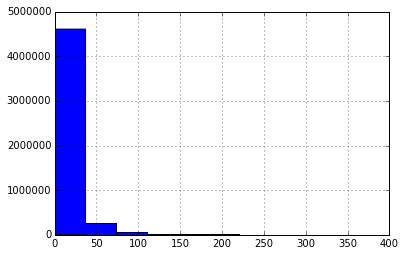

In [43]:
oti_days.hist()

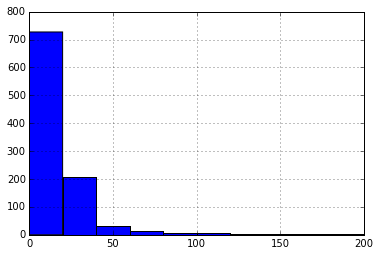

In [44]:
oti_days.sample(1000).hist()

In [102]:
oti_out, oti_bins = pandas.qcut(oti_days, 10, retbins=True)
oti_bins[-1] = int(oti_bins[-1] * 1.01)

In [103]:
oti_bins

array([   0.,    3.,    4.,    7.,    9.,   12.,   15.,   19.,   24.,
         33.,  371.])

In [104]:
oti_out.sample(500).value_counts(sort=False)

[0, 3]       65
(3, 4]       24
(4, 7]       74
(7, 9]       48
(9, 12]      48
(12, 15]     55
(15, 19]     40
(19, 24]     55
(24, 33]     51
(33, 368]    40
dtype: int64

In [105]:
convert(0.5, oti_bins)

13.499999999999998

In [148]:
import functools
reverse_convert_oti = functools.partial(reverse_convert, buckets=oti_bins)
scaled_oti_days = oti_days.apply(reverse_convert_oti)

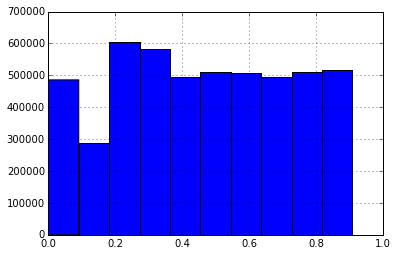

In [149]:
scaled_oti_days.hist()

In [150]:
scaled_oti_days.describe()

count    5000000.000000
mean           0.445235
std            0.256802
min            0.000244
25%            0.242432
50%            0.454346
75%            0.672607
max            0.908447
Name: OUTBOUND_TO_INBOUND, dtype: float64

In [ ]:
training_data['OUTBOUND_TO_INBOUND'] = scaled_oti_days
gc.collect()

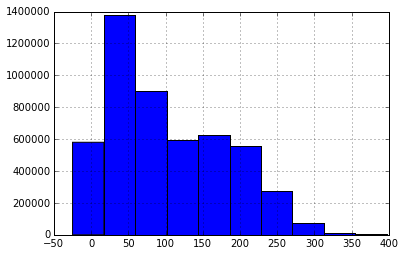

In [49]:
one_day = 1000000000 * 60 * 60 * 24
sto_days = training_data.SEARCH_TO_OUTBOUND.map(lambda x: x.item() / one_day)
sto_days.hist()

In [152]:
sto_out, sto_bins = pandas.qcut(sto_days, 10, retbins=True)
sto_bins[-1] = int(sto_bins[-1] * 1.01)
sto_bins

array([ -25.,   15.,   29.,   43.,   61.,   81.,  112.,  146.,  180.,
        215.,  400.])

In [51]:
sto_out.sample(500).value_counts(sort=False)

[-25, 15]     56
(15, 29]      61
(29, 43]      46
(43, 61]      40
(61, 81]      47
(81, 112]     59
(112, 146]    54
(146, 180]    50
(180, 215]    51
(215, 397]    36
dtype: int64

In [ ]:
reverse_convert_sto = functools.partial(reverse_convert, buckets=sto_bins)
training_data['SEARCH_TO_OUTBOUND'] = sto_days.apply(reverse_convert_sto)
gc.collect()

In [ ]:
sti_days = training_data.SEARCH_TO_INBOUND.map(lambda x: x.item() / one_day)
sti_out, sti_bins = pandas.qcut(sti_days, 10, retbins=True)
sti_bins[-1] = int(sti_bins[-1] * 1.01)
reverse_convert_sti = functools.partial(reverse_convert, buckets=sti_bins)
training_data['SEARCH_TO_INBOUND'] = sti_days.apply(reverse_convert_sti)
gc.collect()

#Airports data

In [19]:
airports_data = pandas.read_csv(airports_fname)

In [20]:
training_merged = pandas.merge(training_data, airports_data, left_on='ORIGIN', right_on='AIRPORT')
del training_data

In [21]:
for key in ('AIRPORT', 'CITY', 'CONTINENT'):
    del training_merged[key]
training_merged.head()

,SEARCH_DATEHOUR,ORIGIN,DESTINATION,OUTBOUND_DATE,INBOUND_DATE,PRICE,MARKETS,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,COUNTRY,LATITUDE,LONGITUDE,TRAFFIC
0,2016-01-04 09:00:00,SZZ,RYG,2016-01-15,2016-01-25,8.84,ES,10 days 15:00:00,20 days 15:00:00,10 days,PL,53.583333,14.9,76133
1,2016-01-03 09:00:00,SZZ,STN,2016-01-20,2016-01-27,16.34,PL,16 days 15:00:00,23 days 15:00:00,7 days,PL,53.583333,14.9,76133
2,2016-01-07 21:00:00,SZZ,RYG,2016-01-29,2016-02-01,17.33,PL,21 days 03:00:00,24 days 03:00:00,3 days,PL,53.583333,14.9,76133
3,2016-01-07 11:00:00,SZZ,STN,2016-03-05,2016-03-06,20.92,PL,57 days 13:00:00,58 days 13:00:00,1 days,PL,53.583333,14.9,76133
4,2016-01-07 13:00:00,SZZ,SVG,2016-01-16,2016-01-19,24.82,PL,8 days 11:00:00,11 days 11:00:00,3 days,PL,53.583333,14.9,76133


In [22]:
for key in ('COUNTRY', 'LATITUDE', 'LONGITUDE', 'TRAFFIC'):
    training_merged['ORIGIN_' + key] = training_merged[key]
    del training_merged[key]

In [23]:
training_merged = pandas.merge(training_merged, airports_data, left_on='DESTINATION', right_on='AIRPORT')
for key in ('AIRPORT', 'CITY', 'CONTINENT'):
    del training_merged[key]
for key in ('COUNTRY', 'LATITUDE', 'LONGITUDE', 'TRAFFIC'):
    training_merged['DESTINATION_' + key] = training_merged[key]
    del training_merged[key]
training_merged.head()

,SEARCH_DATEHOUR,ORIGIN,DESTINATION,OUTBOUND_DATE,INBOUND_DATE,PRICE,MARKETS,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_TRAFFIC,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_TRAFFIC
0,2016-01-04 09:00:00,SZZ,RYG,2016-01-15,2016-01-25,8.84,ES,10 days 15:00:00,20 days 15:00:00,10 days,PL,53.583333,14.900000,76133,NO,59.3789,10.7856,278640
1,2016-01-07 21:00:00,SZZ,RYG,2016-01-29,2016-02-01,17.33,PL,21 days 03:00:00,24 days 03:00:00,3 days,PL,53.583333,14.900000,76133,NO,59.3789,10.7856,278640
2,2016-01-04 11:00:00,SZZ,RYG,2016-01-08,2016-01-11,47.02,PL,3 days 13:00:00,6 days 13:00:00,3 days,PL,53.583333,14.900000,76133,NO,59.3789,10.7856,278640
3,2016-01-09 12:00:00,WMI,RYG,2016-02-04,2016-02-16,16.06,PL,25 days 12:00:00,37 days 12:00:00,12 days,PL,52.460298,20.657294,932470,NO,59.3789,10.7856,278640
4,2016-01-08 21:00:00,WMI,RYG,2016-02-26,2016-02-28,16.06,PL,48 days 03:00:00,50 days 03:00:00,2 days,PL,52.460298,20.657294,932470,NO,59.3789,10.7856,278640


In [24]:
#training_merged = training_merged.sort('PRICE')
del airports_data
gc.collect()

36630

In [25]:
#for key in (
#    'ORIGIN', 'DESTINATION', 'ORIGIN_CITY', 'ORIGIN_COUNTRY', 
#    'ORIGIN_CONTINENT', 'DESTINATION_CITY', 'DESTINATION_COUNTRY', 
#    'DESTINATION_CONTINENT',
#):
#    training_merged[key] = training_merged[key].astype('category')
#training_merged.head()

#Categorical data (one-hot encodings)

##Markets

In [26]:
market_counts = Counter(
    market
    for __, marketlist in 
    training_merged.MARKETS.iteritems()
    for market in
    marketlist.split(';')
)
print market_counts.most_common(10)

[('**', 3442333), ('UK', 487969), ('US', 213188), ('IT', 152141), ('FR', 150781), ('DE', 146748), ('ES', 142819), ('SK', 105670), ('TR', 101978), ('AT', 99244)]


In [27]:
len(market_counts)

248

In [28]:
most_common_markets = [market for market, __ in market_counts.most_common(99)]
print most_common_markets

['**', 'UK', 'US', 'IT', 'FR', 'DE', 'ES', 'SK', 'TR', 'AT', 'PL', 'PT', 'RU', 'IE', 'HU', 'CZ', 'GR', 'BR', 'BG', 'RO', 'NL', 'CH', 'TW', 'HK', 'MT', 'IL', 'BE', 'SA', 'CA', 'KW', 'MO', 'SI', 'QA', 'KZ', 'BH', 'IS', 'OM', 'BY', 'GE', 'ME', 'MD', 'LB', 'AZ', 'AD', 'SM', 'VA', 'HR', 'LI', 'BA', 'GL', 'FO', 'MK', 'KO', 'BV', 'MN', 'LU', 'WF', 'TF', 'BN', 'WS', 'TL', 'GU', 'PW', 'PG', 'PN', 'MP', 'FJ', 'FM', 'VU', 'NU', 'CK', 'CC', 'CX', 'KH', 'SB', 'TV', 'TO', 'TK', 'AS', 'LK', 'MV', 'BT', 'BQ', 'GS', 'HM', 'MH', 'UM', 'MS', 'NF', 'CW', 'SX', 'KI', 'SJ', 'LA', 'AN', 'AQ', 'IO', 'MC', 'RS']


In [29]:
market_onehots = np.zeros((len(training_merged.MARKETS), 100), dtype='bool')
for i, (marketlist, onehot) in enumerate(itertools.izip(training_merged.MARKETS, market_onehots)):
    ms = marketlist.split(';')
    for m in ms:
        try:
            onehot[most_common_markets.index(m)] = True
        except ValueError:
            onehot[-1] = True
    if not i % 1000000:
        print i

0
1000000
2000000
3000000
4000000


In [30]:
training_merged.MARKETS.tail(2)

4999998                                                   **
4999999    VN;IN;KW;ID;HM;TH;TR;UM;MY;MH;IL;GI;NF;MO;TW;W...
Name: MARKETS, dtype: object

In [31]:
sum(market_onehots[-1])

83

In [32]:
sum(market_onehots[-2])

1

In [33]:
import gc
gc.collect()

9

In [34]:
training_merged['MARKETS'] = list(market_onehots)
training_merged.MARKETS.loc[0]

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [35]:
del market_onehots
gc.collect()

10

In [36]:
training_merged.MARKETS.head()

0    [False, False, False, False, False, False, Tru...
1    [False, False, False, False, False, False, Fal...
2    [False, False, False, False, False, False, Fal...
3    [False, False, False, False, False, False, Fal...
4    [False, False, False, False, False, False, Fal...
Name: MARKETS, dtype: object

In [37]:
training_merged.dtypes

SEARCH_DATEHOUR           datetime64[ns]
ORIGIN                            object
DESTINATION                       object
OUTBOUND_DATE             datetime64[ns]
INBOUND_DATE              datetime64[ns]
PRICE                            float64
MARKETS                           object
SEARCH_TO_OUTBOUND       timedelta64[ns]
SEARCH_TO_INBOUND        timedelta64[ns]
OUTBOUND_TO_INBOUND      timedelta64[ns]
ORIGIN_COUNTRY                    object
ORIGIN_LATITUDE                  float64
ORIGIN_LONGITUDE                 float64
ORIGIN_TRAFFIC                     int64
DESTINATION_COUNTRY               object
DESTINATION_LATITUDE             float64
DESTINATION_LONGITUDE            float64
DESTINATION_TRAFFIC                int64
dtype: object

##Other

In [38]:
def make_onehot(df, field, size):
    series = df[field]
    counts = Counter(series)
    print len(counts)
    most_common = [item for item, __ in counts.most_common(size)]
    print most_common
    most_common_set = frozenset(most_common)
    excluded = sum(place not in most_common_set for place in series) / float(len(series))
    print excluded
    zeros_size = len(most_common) + (1 if excluded > 0 else 0)
    onehots = np.zeros((len(series), zeros_size), dtype='bool')
    most_common_index = most_common.index
    for i, (item, onehot) in enumerate(itertools.izip(series, onehots)):
        try:
            onehot[most_common_index(item)] = True
        except ValueError:
            onehot[zeros_size - 1] = True
        if not i % 1000000:
            print i
    df[field] = list(onehots)
    return df

In [39]:
pairs = {
    'ORIGIN': 149,
    'ORIGIN_COUNTRY': 49,
    'DESTINATION': 224,
    'DESTINATION_COUNTRY': 49,
}
for field, size in pairs.iteritems():
    print field
    gc_collect_1 = gc.collect()
    training_merged = make_onehot(training_merged, field, size)
    print gc.collect() + gc_collect_1

ORIGIN
2150
['MAN', 'LHR', 'FRA', 'LGW', 'CDG', 'AMS', 'MAD', 'BHX', 'DUS', 'MUC', 'STN', 'MXP', 'BRU', 'GLA', 'SVO', 'FCO', 'HAM', 'BCN', 'GRU', 'IST', 'GIG', 'ZRH', 'MEX', 'STR', 'CGN', 'EMA', 'YYZ', 'DUB', 'CUN', 'TXL', 'DME', 'CPH', 'NCL', 'ATH', 'VCE', 'VIE', 'LIS', 'LAX', 'WAW', 'BUD', 'GVA', 'BLQ', 'LED', 'HAJ', 'LIN', 'BRS', 'EDI', 'JFK', 'HEL', 'PRG', 'ORY', 'ARN', 'LBA', 'SFO', 'EZE', 'LPL', 'OSL', 'SXF', 'BIO', 'MSP', 'OPO', 'LYS', 'TFS', 'IAH', 'DFW', 'BOG', 'BWI', 'BLL', 'MRS', 'RIX', 'BSL', 'PDX', 'TLL', 'BSB', 'LTN', 'SJO', 'SEA', 'BKK', 'TLV', 'VCP', 'OAK', 'POA', 'PMI', 'VNO', 'SOF', 'SIN', 'SCL', 'BGY', 'AYT', 'LEJ', 'REC', 'AAL', 'TLS', 'YUL', 'NCE', 'LJU', 'CNF', 'MCO', 'FOR', 'YVR', 'LAS', 'KBP', 'FLR', 'BEG', 'LCA', 'BRE', 'OTP', 'ZAG', 'BFS', 'CWL', 'CPT', 'SJC', 'KRK', 'DEN', 'BUR', 'TRN', 'BOS', 'JED', 'ORD', 'VRN', 'JNB', 'SKG', 'AGP', 'GOT', 'SSA', 'LIM', 'GDL', 'CCS', 'HAV', 'NAP', 'ONT', 'CAI', 'SYD', 'PHX', 'LCY', 'NUE', 'AUS', 'CWB', 'ISP', 'FLL', 'MEL', 

In [41]:
training_merged.to_pickle('my_data/TrainingMerged.pickle')

In [52]:
gc.collect()

83

Doesn't seem like we need to rescale traffics based on distributions

In [86]:
price_step = 1 / 142.
print price_step
price_bucket_ranges = zip(buckets, buckets[1:])
def convert(num, bucket_ranges=price_bucket_ranges, step=price_step):
    """go from 0..1 to larger"""
    cumsum = 0
    for low, high in bucket_ranges:
        if cumsum <= num < cumsum + step:
            t = (num - cumsum) / step
            return (1 - t) * low + t * high
        cumsum += step
    t = (num - (cumsum - step)) / step
    return (1 - t) * low + t * high

def reverse_convert(num, bucket_ranges=price_bucket_ranges, step=price_step):
    """go from larger to 0..1"""
    # Binary search, because I couldn't spend time to figure it out properly... oh well
    fn = lambda x: convert(x, bucket_ranges=bucket_ranges, step=step)
    high, low = 0., 1.
    for __ in xrange(50):
        mid = (high + low) / 2.
        result = fn(mid)
        if fn(mid) > num:
            low = mid
        else:
            high = mid
    return mid
reverse_convert(1087.7000000000012)

0.00704225352113


0.7500000000000009

In [85]:
convert(0.75)

1087.7000000000012